In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 27.8 MB/s 
     |████████████████████████████████| 7.6 MB 82.0 MB/s 
     |████████████████████████████████| 182 kB 100.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 19.6 MB/s 
     |████████████████████████████████| 132 kB 92.4 MB/s 
     |████████████████████████████████| 212 kB 99.3 MB/s 
     |████████████████████████████████| 127 kB 100.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


### Model

In [ ]:
from transformers import AutoTokenizer,BertModel
from datasets import Dataset
import torch
import torch.nn as nn
from torch.utils.data import RandomSampler, DataLoader,SequentialSampler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import notebook
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
#change pretrained models?
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-esg',model_max_length=256)
esg_bert = BertModel.from_pretrained('yiyanghkust/finbert-esg',output_attentions=True) 

Downloading:   0%|          | 0.00/781 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of the model checkpoint at yiyanghkust/finbert-esg were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/'NLP Final Project'

/content/drive/.shortcut-targets-by-id/1idaRkfcIlcNE-cXtRtSk3Qo9QdbhAh4Q/NLP Final Project


In [ ]:
#way 1
final_dataset = pd.read_csv("final_dataset_new.csv")

In [ ]:
final_dataset

,symbol,year,truncated_text,score
0,a,2016,if it meets it will likely react the way the a...,0.884762
1,a,2021,we’ve changed lives for the better and took mo...,0.886514
2,aal,2020,"$jets, $play, &amp; $aal gains [ericsson profi...",0.622026
3,aal,2021,$aal lets gooooooo! $aal letsssss gooooooooooo...,0.685919
4,aap,2016,with all these uber and lyft cars on these str...,0.333698
...,...,...,...,...
837,xray,2021,"as of now, only about ⅓ of align’s customers a...",0.678117
838,xyl,2020,the applied water segment encompasses the uses...,0.826304
839,yum,2021,can nuggets do the same? i don't care.tldr – *...,0.772902
840,zts,2016,$pzza- buy a 75/80 nov16 call spread or sell n...,0.452652


In [ ]:
from sklearn.model_selection import train_test_split
train_text,val_text,train_score,val_score = train_test_split(list(final_dataset["truncated_text"]),list(final_dataset["score"]),test_size=0.2)

In [ ]:
def getGrade(score):
    if score <= 0.25:
        return 0
    elif score <= 0.50:
        return 1
    elif score <= 0.75:
        return 2
    elif score <= 1:
        return 3

In [ ]:
train_grade = [getGrade(score) for score in train_score]
val_grade = [getGrade(score) for score in val_score]

In [ ]:
train_dataset = pd.DataFrame({"train_text":train_text,"train_grade":train_grade})
val_dataset = pd.DataFrame({"val_text":val_text,"val_grade":val_grade})

In [ ]:
train_encoding = tokenizer(train_text,truncation=True,padding=True)
val_encoding = tokenizer(val_text,truncation=True,padding=True)

In [ ]:
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = RedditDataset(train_encoding,train_grade)
val_dataset = RedditDataset(val_encoding,val_grade)

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(self, bert, num_classes):
        super().__init__()
        self.bert = bert
        self.W = nn.Linear(bert.config.hidden_size, num_classes)
        self.num_classes = num_classes
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        h, _, attn = self.bert(input_ids=input_ids, 
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids).values()
        h_cls = h[:,0,:]
        output = self.W(h_cls)
        return output, attn

In [ ]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
        
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [ ]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler,batch_size=4)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=4)

In [ ]:
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'

In [ ]:
model = ClassificationModel(esg_bert,4)
freeze_model(model.bert)

In [ ]:
def train_and_val(model,num_epochs):
    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=2e-04, eps=1e-08)
    criterion = nn.CrossEntropyLoss().to(device)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=0, verbose=True)

    model.to(device)

    # Train!
    train_losses = []
    val_losses =[]
    model.zero_grad()
    for i in notebook.tqdm(range(num_epochs), desc="Epoch"):
        epoch_iterator = notebook.tqdm(train_dataloader, desc="Training")
        train_losses_batch = []
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(batch[t].to(device) for t in batch)
            logits, _ = model(*batch[:-1])

            labels = batch[-1]
            train_loss = criterion(logits.view(-1,model.num_classes), labels.view(-1))
            
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            train_losses_batch.append(train_loss.item())
            optimizer.step()
            model.zero_grad()
        train_losses.append(np.mean(train_losses_batch))
        print("Epoch {}: training loss {} ".format(i+1,np.mean(train_losses_batch)))
        # Eval!
        val_losses_batch = []
        for batch in notebook.tqdm(val_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(batch[t].to(device) for t in batch)

            with torch.no_grad():
                logits, attn = model(*batch[:-1])
                
                labels = batch[-1]
                val_loss = criterion(logits.view(-1,model.num_classes), labels.view(-1))
                val_losses_batch.append(val_loss.item())
        val_losses.append(np.mean(val_losses_batch))
        scheduler.step(np.mean(val_losses_batch))
        print("Epoch {}: val loss {} ".format(i+1,np.mean(val_losses_batch)))
    return train_losses,val_losses


In [23]:
train_losses,val_losses = train_and_val(model, 50) #epoch can change?

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 1: training loss 1.1053433947309235 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 1: val loss 1.136739621328753 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 2: training loss 1.0594391794599725 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 2: val loss 1.1312558401462645 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 3: training loss 1.0596097982846773 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 3: val loss 1.109771304352339 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 4: training loss 1.050709915584361 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 00004: reducing learning rate of group 0 to 2.0000e-05.
Epoch 4: val loss 1.1242647531420686 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 5: training loss 1.0225346980715644 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 00005: reducing learning rate of group 0 to 2.0000e-06.
Epoch 5: val loss 1.1147960493730944 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 6: training loss 1.020424629104208 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 2.0000e-07.
Epoch 6: val loss 1.114747779313908 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 7: training loss 1.0160613543183141 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 2.0000e-08.
Epoch 7: val loss 1.1147525560024172 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 8: training loss 1.01756422442092 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 00008: reducing learning rate of group 0 to 2.0000e-09.
Epoch 8: val loss 1.1147543787956238 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 9: training loss 1.0212622105017217 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 9: val loss 1.1147544425587321 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 10: training loss 1.0188278601719782 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 10: val loss 1.1147544176079507 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 11: training loss 1.0207008165720652 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 11: val loss 1.1147543774094693 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 12: training loss 1.0149848715088072 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 12: val loss 1.1147542443386345 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 13: training loss 1.0222036545798623 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 13: val loss 1.1147542817648066 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 14: training loss 1.0141733500379078 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 14: val loss 1.1147540655247001 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 15: training loss 1.0196878698450573 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 15: val loss 1.1147540017615918 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 16: training loss 1.0176452179632243 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 16: val loss 1.1147538894830749 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 17: training loss 1.0204999319900423 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 17: val loss 1.1147538201753484 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 18: training loss 1.0218126593962225 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 18: val loss 1.114753597004469 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 19: training loss 1.0232031405324766 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 19: val loss 1.1147534098736076 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 20: training loss 1.014944825299393 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 20: val loss 1.1147533100704814 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 21: training loss 1.018785928833414 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 21: val loss 1.1147532740304635 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 22: training loss 1.0251622653219121 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 22: val loss 1.1147531451180923 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 23: training loss 1.0232169014462353 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 23: val loss 1.1147530259088028 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 24: training loss 1.017745149911508 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 24: val loss 1.1147530966026837 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 25: training loss 1.026337199662564 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 25: val loss 1.1147529330364494 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 26: training loss 1.0166879359787033 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 26: val loss 1.11475303422573 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 27: training loss 1.0175977853628306 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 27: val loss 1.1147533239320266 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 28: training loss 1.0239107908581841 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 28: val loss 1.1147532158119733 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 29: training loss 1.0165371760814148 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 29: val loss 1.114753081354984 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 30: training loss 1.0153732137567193 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 30: val loss 1.1147527708563694 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 31: training loss 1.0202190787834529 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 31: val loss 1.1147526502609253 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 32: training loss 1.0241957938177346 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 32: val loss 1.1147523758023283 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 33: training loss 1.0139749720251772 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 33: val loss 1.1147523369900016 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 34: training loss 1.020757818363122 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 34: val loss 1.1147520361944687 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 35: training loss 1.0197788935441237 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 35: val loss 1.1147516744081365 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 36: training loss 1.0165192534232281 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 36: val loss 1.1147515940111736 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 37: training loss 1.0148915406867598 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 37: val loss 1.114751513614211 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 38: training loss 1.0186888420370204 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 38: val loss 1.1147514886634295 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 39: training loss 1.0204715647641018 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 39: val loss 1.1147514845049658 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 40: training loss 1.0117027748971297 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 40: val loss 1.114751508069593 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 41: training loss 1.0160320147254762 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 41: val loss 1.1147512239079143 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 42: training loss 1.0150402992434755 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 42: val loss 1.114751124104788 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 43: training loss 1.01529884514724 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 43: val loss 1.1147509688554809 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 44: training loss 1.0182707588348163 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 44: val loss 1.114751233610996 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 45: training loss 1.023453237742362 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 45: val loss 1.114751139352488 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 46: training loss 1.0197233250860631 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 46: val loss 1.1147511296494061 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 47: training loss 1.024565608191067 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 47: val loss 1.1147507928138556 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 48: training loss 1.019703716745038 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 48: val loss 1.114750511424486 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 49: training loss 1.0207103282742247 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 49: val loss 1.114750514196795 


Training:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 50: training loss 1.0187898756131617 


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]

Epoch 50: val loss 1.1147504781567774 


In [24]:
def plot_over_training(per_epoch_metrics, title_name: str):
  """Utility function to plot train/val accuracies and losses.

  @param per_epoch_metrics: a dictionary of lists, where each list represents a metric over the
      course of training.
  @param title_name: String to show on the plot title.
  """
  t_train = np.arange(0, len(per_epoch_metrics['train_losses']))
  train_loss = per_epoch_metrics['train_losses']

  t_val = np.arange(0, len(per_epoch_metrics['val_losses']))
  val_loss = per_epoch_metrics['val_losses']

  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss', color=color)
  ax1.plot(t_train, train_loss, color=color, linewidth=1, label = 'train_loss')
  ax1.plot(t_val, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.legend(loc='upper left')

  fig.tight_layout() 
  plt.title(title_name)
  plt.show()

In [25]:
per_epoch_metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
}

title_name = 'Classification: freeze_model, lr=2e-04, eps=1e-08'

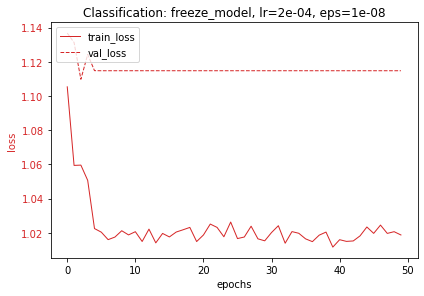

In [26]:
plot_over_training(per_epoch_metrics=per_epoch_metrics, title_name=title_name)

In [27]:
torch.save(model.state_dict(), './models/finbert-esg-reddit-classification-state_dict.pt')

In [28]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# model_benchmark = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg', 
#                                                            num_labels = 1,ignore_mismatched_sizes=True)